In [1]:
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_variable(domain='atm',var='TREFHT',h='h0',runname='coupled_BGC_defParams_SpinUp_001'):
    fpath = '/glade/scratch/czarakas/archive/'+runname+'/'+domain+'/proc/tseries/'
    fname = fpath+'*'+h+'*.'+var+'*.nc'
    #print(fname)
    ds = xr.open_mfdataset(fname, combine='by_coords')
    return ds

In [3]:
def global_avg_atm(ds, var):
    coslat = np.cos(np.deg2rad(ds.lat))
    atm_weights = coslat / coslat.mean(dim='lat') 
    
    return (ds[var]*atm_weights).mean(dim=['lat','lon'])

In [4]:
ds1=xr.open_dataset('/glade/scratch/czarakas/archive/coupled_BGC_defParams_SpinUp_001/atm/hist/coupled_BGC_defParams_SpinUp_001.cam.h0.0001-01.nc')
ds2=xr.open_dataset('/glade/scratch/czarakas/archive/coupled_BGC_defParams_SpinUp_001/lnd/hist/coupled_BGC_defParams_SpinUp_001.clm2.h0.0001-02-01-00000.nc')

# Calculate area weights

In [5]:
#Atmosphere weights
weight_factor2 = ds1.gw / ds1.gw.mean(dim='lat')

#Land weights
land_area=ds2.area*ds2.landfrac
landweights = land_area/land_area.sum(dim=['lat','lon'])

#Land weights
def land_weights_region(minlat=-100,maxlat=100,ds_lnd=ds2):
    land_area=ds_lnd.area*ds_lnd.landfrac
    land_area=land_area.where(land_area.lat>=minlat).where(land_area.lat<=maxlat)
    landweights = land_area/land_area.sum(dim=['lat','lon'])
    return landweights

# Check that CO_2 isn't changing over time (it should be constant!) and that it is about the right concentration
Should be ~388.72 (from Meinshausen et al. 2017)
Check this is true for both the atmosphere AND the land
This is ~1.35x pre-industrial concentrations, so if things were linear (which they're not), we should expect global temperature change to be ~0.35x of the equilibrium climate sensitivity. CESM2 has an ECS of 5.3K, so the temperature change should be ~1.85K?

In [6]:
ds_atm=get_variable(domain='atm',var='co2vmr',h='h0')

Text(0, 0.5, 'CO2 concentration (ppm)')

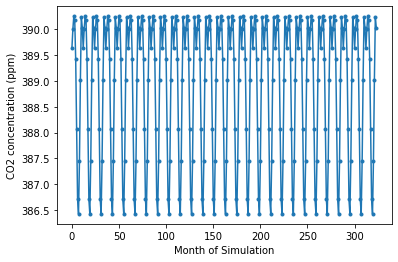

In [7]:
plt.plot(ds_atm.co2vmr*1e6,'.-')
plt.xlabel('Month of Simulation')
plt.ylabel('CO2 concentration (ppm)')

In [8]:
print(ds_atm.co2vmr.mean(dim='time').values*1e6)

388.9523288147823


Text(0, 0.5, 'CO2 concentration (ppm)')

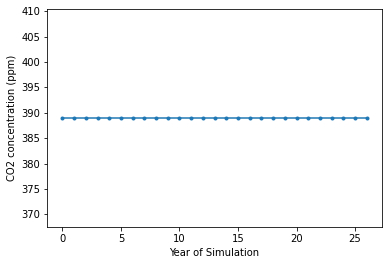

In [9]:
plt.plot(ds_atm.co2vmr.groupby('time.year').mean()*1e6,'.-')
plt.xlabel('Year of Simulation')
plt.ylabel('CO2 concentration (ppm)')

# Look at temperature

In [10]:
ds_trefht=get_variable(domain='atm',var='TREFHT',h='h0')
trefht_glb=global_avg_atm(ds_trefht, var='TREFHT')

In [11]:
def atm_weights_region(minlat=-100,maxlat=100,ds=ds1):
    gw=ds.gw
    gw=gw.where(gw.lat>=minlat).where(gw.lat<=maxlat)
    return gw/gw.mean(dim='lat')

In [12]:
tmonths = np.arange(0, np.size(ds_trefht.time))/12
tyears = np.arange(0, np.size(ds_trefht.time.groupby('time.year').mean(dim='time')))+0.5

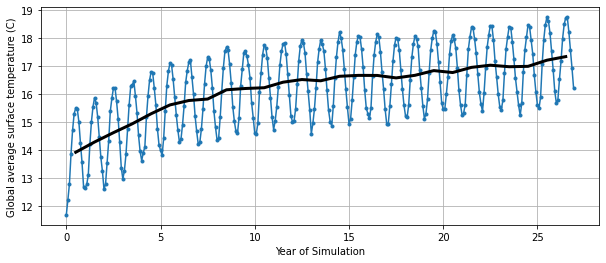

In [13]:
plt.figure(figsize=(10,4))
plt.plot(tmonths, trefht_glb-273.15,'.-')
plt.plot(tyears,trefht_glb.groupby('time.year').mean(dim='time')-273.15,
         '-k',linewidth=3)
plt.xlabel('Year of Simulation')
plt.ylabel('Global average surface temperature (C)')
plt.grid()
#plt.xlim([0,20])
plt.savefig('Spinup_global_temperature.png')

# Look at atmospheric quantities in different latitudinal belts

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


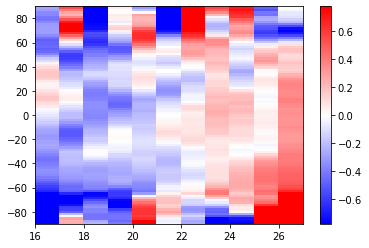

In [21]:
var = 'TREFHT'
yr_spin_up_done=15
var_series = ds_trefht[var]-273.15

var_zonal_mean = var_series.mean(dim='lon')
var_zonal_mean = var_zonal_mean.groupby('time.year').mean(dim='time')
var_zonal_mean=var_zonal_mean[yr_spin_up_done:,:]
var_zonal_mean = var_zonal_mean - var_zonal_mean.mean(dim='year')
cbound = np.max(np.abs([np.nanpercentile(var_zonal_mean,95),np.nanpercentile(var_zonal_mean,5)]))
plt.pcolor(var_zonal_mean.year, var_zonal_mean.lat, var_zonal_mean.transpose(), cmap=plt.cm.bwr,
          vmin=-cbound, vmax=cbound)#, tlai_zonal_mean.time, tlai_zonal_mean.lat)
#plt.ylim([-90,90])
plt.colorbar()

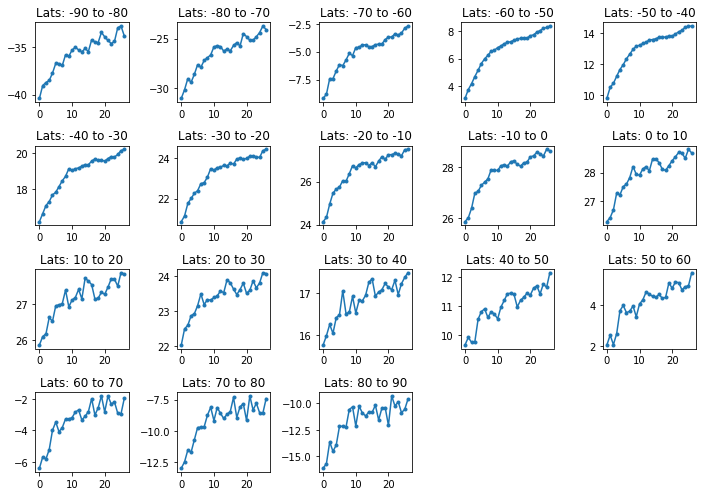

In [15]:
latrange_min=-90
dlat=10
plt.figure(figsize=(10,7))
for i in np.arange(0,int(180/dlat)):
    latmin=latrange_min+(dlat*i)
    latmax=latrange_min+(dlat*(i+1))
    weights_region=atm_weights_region(minlat=latmin,maxlat=latmax)
    label="Lats: "+str(latmin)+" to "+str(latmax)
    annual_var=(ds_trefht[var]*weights_region).mean(dim=['lat','lon']).groupby('time.year').mean(dim='time')-273.15
    plt.subplot(4,5,i+1)
    plt.plot(annual_var,'.-')
    plt.title(label)
    #plt.ylim([0,np.nanmax(annual_LAI)*1.2])
plt.tight_layout()

# Look at global average LAI

In [16]:
ds_lnd=get_variable(domain='lnd',var='TLAI',h='h0',runname='coupled_BGC_defParams_SpinUp_001')

Text(0, 0.5, 'Global average LAI')

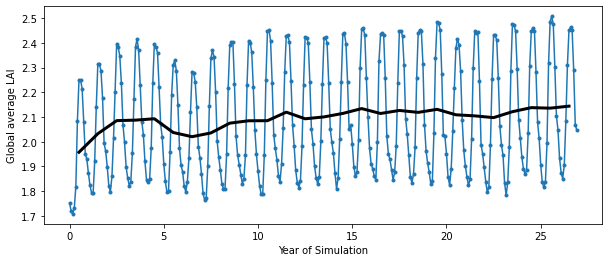

In [17]:
plt.figure(figsize=(10,4))
plt.plot(tmonths, 
         (ds_lnd.TLAI*landweights).sum(dim=['lat','lon']),
         '.-')
plt.plot(tyears,
         (ds_lnd.TLAI*landweights).sum(dim=['lat','lon']).groupby('time.year').mean(dim='time'),
         '-k',linewidth=3)
plt.xlabel('Year of Simulation')
plt.ylabel('Global average LAI')

# Look at land quantities in different latitudinal belts

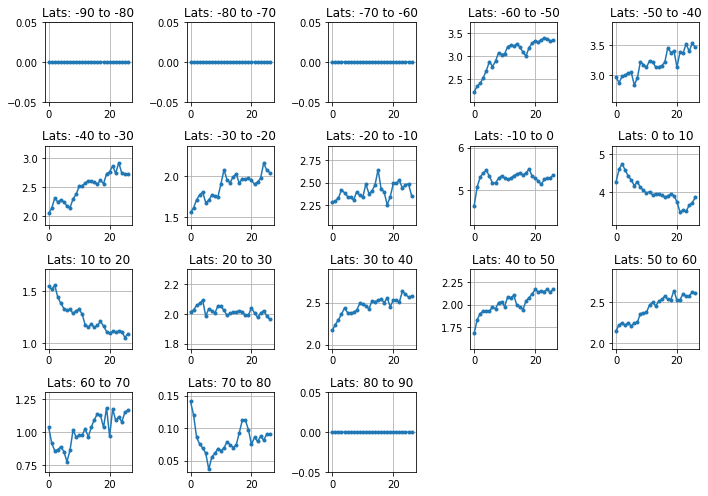

In [18]:
latrange_min=-90
dlat=10
plt.figure(figsize=(10,7))
for i in np.arange(0,int(180/dlat)):
    latmin=latrange_min+(dlat*i)
    latmax=latrange_min+(dlat*(i+1))
    landweights_region=land_weights_region(minlat=latmin,maxlat=latmax)
    label="Lats: "+str(latmin)+" to "+str(latmax)
    annual_mean=(ds_lnd.TLAI*landweights_region).sum(dim=['lat','lon']).groupby('time.year').mean(dim='time')
    plt.subplot(4,5,i+1)
    plt.plot(annual_mean,'.-')
    #plt.plot(annual_mean,'.-')
    plt.title(label)
    if np.nanmax(annual_mean)<0.01:
        plt.ylim([-0.05,0.05])
    else:
        plt.ylim([np.nanmin(annual_mean)*0.9,np.nanmax(annual_mean)*1.1])
    plt.grid()
plt.tight_layout()

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later

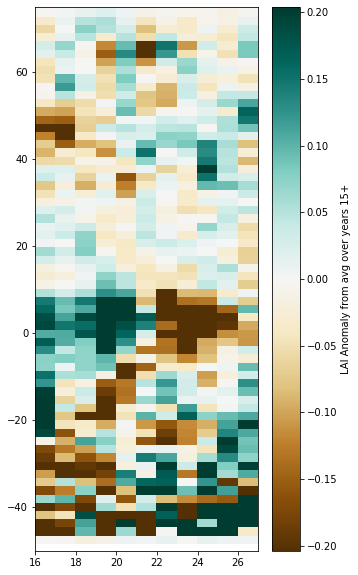

In [32]:
var = 'TLAI'
yr_spin_up_done=15
var_series = ds_lnd[var]-273.15

plt.figure(figsize=(5,10))
var_zonal_mean = var_series.where(ds2.landfrac==1).mean(dim='lon')
var_zonal_mean = var_zonal_mean.groupby('time.year').mean(dim='time')
var_zonal_mean=var_zonal_mean[yr_spin_up_done:,:]
var_zonal_mean = var_zonal_mean - var_zonal_mean.mean(dim='year')
cbound = np.max(np.abs([np.nanpercentile(var_zonal_mean,95),np.nanpercentile(var_zonal_mean,5)]))
plt.pcolor(var_zonal_mean.year, var_zonal_mean.lat, var_zonal_mean.transpose(), cmap=plt.cm.BrBG,
          vmin=-cbound, vmax=cbound)#, tlai_zonal_mean.time, tlai_zonal_mean.lat)
plt.ylim([-50,75])
plt.colorbar(label='LAI Anomaly from avg over years '+str(yr_spin_up_done)+'+')

# Context for zonal means: how much of each latitude band is land

(-90.0, 90.0)

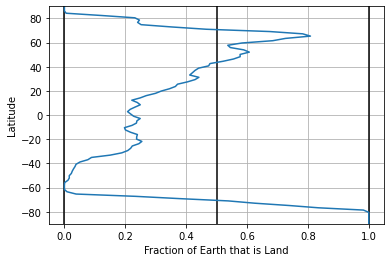

In [20]:
landfrac_full = ds2.landfrac.fillna(0)[:,:]
plt.plot([0,0],[-90,90],'-k')
plt.plot([0.5,0.5],[-90,90],'-k')
plt.plot([1,1],[-90,90],'-k')
plt.plot(landfrac_full.mean(dim='lon'),ds_lnd.lat)
plt.grid()
plt.xlabel('Fraction of Earth that is Land')
plt.ylabel('Latitude')
plt.ylim([-90,90])